# RDF

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/rudof-project/tutorials/blob/main/rudof/rdf.ipynb)

This document contains a short introduction to [RDF](https://www.w3.org/TR/rdf11-primer/) using [rudof](https://rudof-project.github.io/).


## Preliminaries: install and configure rudof

The library is available as `pyrudof`.

In [2]:
!pip install pyrudof

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 66.6 MB/s eta 0:00:00


The main entry point if a class called [`Rudof`](https://pyrudof.readthedocs.io/en/stable/library.html#rudof) through which most of the functionality is provided.

In [3]:
from pyrudof import Rudof, RudofConfig

In order to initialize that class, it is possible to pass a [`RudofConfig`](https://pyrudof.readthedocs.io/en/stable/library.html#pyrudof.RudofConfig) instance which contains configuration parameters for customization. An instance of `RudofConfig` can be obtained from the default initialization method or can be read from a TOML file.

In [4]:
rudof = Rudof(RudofConfig())

We will use `Image` to visualize images of RDF graphs generated using `rudof` and `plantuml`.

In [5]:
!pip install plantuml
from IPython.display import Image # For displaying images

The method `reset_all()` can be useful to clean the previous contents of `rudof`.

In [6]:
rudof.reset_all()

## RDF data model

RDF is based on statements or triples of the form `<subject> <predicate> <object>` where the predicates are identified by IRIs and in the most basic form, subjects and objects are also IRIs. An example could be: `<http://example.org/alice> <http://example.org/knows> <http:/example.org/bob>`.

In `rudof`, it is possible to load a triple as follows:

In [7]:
rudof.read_data_str("<http://example.org/alice> <http://example.org/knows> <http://example.org/bob> .")

RDF graphs are defined as a set of triples. In the basic notation, a set of triples is just one triple after another separated by a dot. So we can add more statements as:

In [8]:
rudof.read_data_str("""
  <http://example.org/alice> <http://example.org/knows> <http://example.org/carol> .
  <http://example.org/alice> <http://example.org/worksFor> <http://example.org/acme> .
  <http://example.org/alice> <http://example.org/birthPlace> <http://example.org/spain> .
  <http://example.org/carol> <http://example.org/knows> <http://example.org/bob> .
  <http://example.org/bob> <http://example.org/knows> <http://example.org/alice> .
""")

Rudof can be used to visualize small RDF triples.

[{'filename': 'out.puml', 'gen_success': True}]


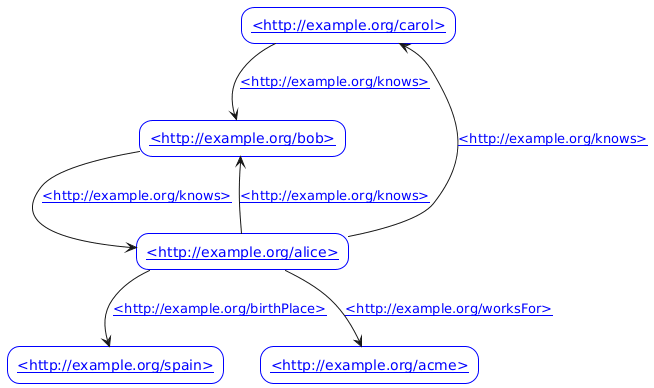

In [9]:
uml = rudof.data2plantuml_file('out.puml')
!python -m plantuml out.puml
Image(f"out.png")

In order to obtain interoperability, it is better to employ IRIs of some agreed vocabularies. In this case, we could use the predicate [`<https://schema.org/knows>`](https://schema.org/knows), [`https://schema.org/worksFor`](https://schema.org/worksFor) and [`https://schema.org/birthPlace`](https://schema.org/birthPlace) from [Schema.org](https://schema.org/), and [`<http://dbpedia.org/resource/Spain`] from [DBpedia](https://dbpedia.org/) to represent Spain.

In [10]:
rudof.reset_all()
rudof.read_data_str("""
  <http://example.org/alice> <https://schema.org/knows>      <http://example.org/carol> .
  <http://example.org/alice> <https://schema.org/worksFor>   <http://example.org/acme> .
  <http://example.org/alice> <https://schema.org/birthPlace> <http://dbpedia.org/resource/Spain> .
  <http://example.org/carol> <https://schema.org/knows>      <http://example.org/bob> .
  <http://example.org/bob>   <http://schema.org/knows>       <http://example.org/alice> .
""")

[{'filename': 'out.puml', 'gen_success': True}]


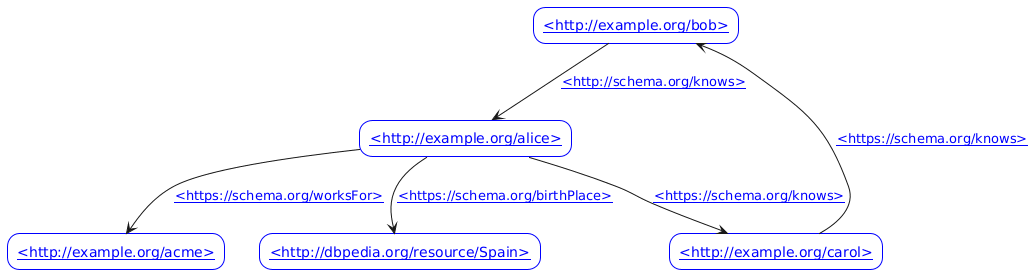

In [11]:
!rm -f out.puml out.png
uml = rudof.data2plantuml_file('out.puml')
!python -m plantuml out.puml
Image(f"out.png")

Having long IRIs can make RDF difficult to read. In order to have more readable RDF documents, it is possible to declare prefixes for some URIs and use qualified names formed by `prefix:name`. So the previous example could be rewritten as:

### Prefixed declarations and qualified names

In [12]:
rudof.reset_all()
rudof.read_data_str("""
 prefix : <http://example.org/>
 prefix schema: <http://schema.org/>
 prefix dbr: <http://dbpedia.org/resource/>

 :alice schema:knows :carol .
 :alice schema:worksFor :acme .
 :alice schema:birthPlace :spain .
 :carol schema:knows :bob .
 :bob   schema:knows :alice .
""")

[{'filename': 'out.puml', 'gen_success': True}]


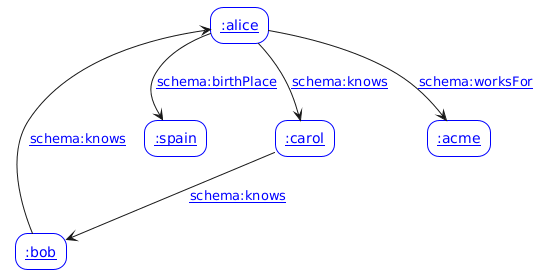

In [13]:
!rm -f out.puml out.png
uml = rudof.data2plantuml_file('out.puml')
!python -m plantuml out.puml
Image(f"out.png")

### RDF Literals

Apart from IRIs, the objects in triples can also be literals, which can be seen as constants. There are 3 types of literals:


* Plain strings, like `"Robert Smith"`
* Language tagged strings, like `"Spain"@en` or `"España@es"`
* Datatype literals, like `"23"^^xsd:integer`


In [14]:
rudof.reset_all()
rudof.read_data_str("""
 prefix : <http://example.org/>
 prefix schema: <http://schema.org/>
 prefix dbr: <http://dbpedia.org/resource/>
 prefix xsd: <http://www.w3.org/2001/XMLSchema#>

 :alice schema:knows :carol .
 :alice schema:worksFor :acme .
 :alice schema:birthPlace dbr:Spain .
 :alice schema:birthDate "1990-01-01"^^xsd:date .
 :carol schema:knows :bob .
 :bob   schema:name "Robert Smith" .
 :bob   schema:knows :alice .
 :acme  schema:name "Acme Inc." .
""")


[{'filename': 'out.puml', 'gen_success': True}]


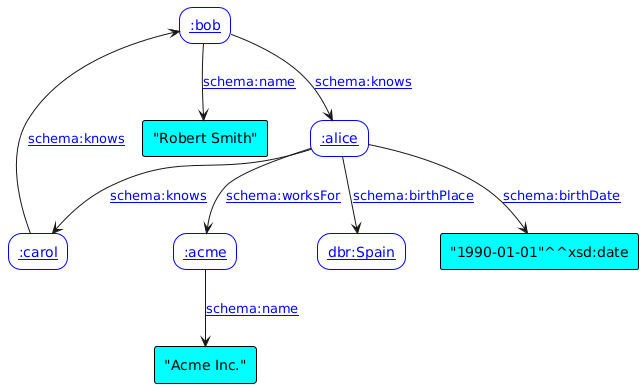

In [15]:
!rm -f out.puml out.png
uml = rudof.data2plantuml_file('out.puml')
!python -m plantuml out.puml
Image(f"out.png")

### Blank nodes

Sometimes, we want to add some statements about things which don't have some IRI. For example, we may want to say that `:alice` knows someone who was born in Italy that works for `Acme` as:

In [16]:
rudof.reset_all()
rudof.read_data_str("""
 prefix : <http://example.org/>
 prefix schema: <http://schema.org/>
 prefix dbr: <http://dbpedia.org/resource/>
 prefix xsd: <http://www.w3.org/2001/XMLSchema#>

 :alice schema:knows _:1 .
 _:1 schema:worksFor :acme .
 _:1 schema:birthPlace dbr:Italy .
""")
#

[{'filename': 'out.puml', 'gen_success': True}]


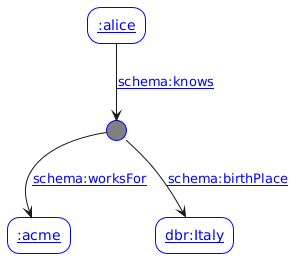

In [17]:
!rm -f out.puml out.png
uml = rudof.data2plantuml_file('out.puml')
!python -m plantuml out.puml
Image(f"out.png")

The notation `_:id` represents a blank node. The `id` of the blank node can be used to refer to it in the definition of the RDF graph, but there is no warranty that it will be preserved internally.

If we want to add that `:bob` knows someone who works for `Acme` and was born in `Germany`, we can do the following:

In [18]:
rudof.read_data_str("""
 prefix : <http://example.org/>
 prefix schema: <http://schema.org/>
 prefix dbr: <http://dbpedia.org/resource/>
 prefix xsd: <http://www.w3.org/2001/XMLSchema#>

 :bob schema:knows _:2 .
 _:2 schema:worksFor :acme .
 _:2 schema:birthPlace dbr:Germany .
""")

[{'filename': 'out.puml', 'gen_success': True}]


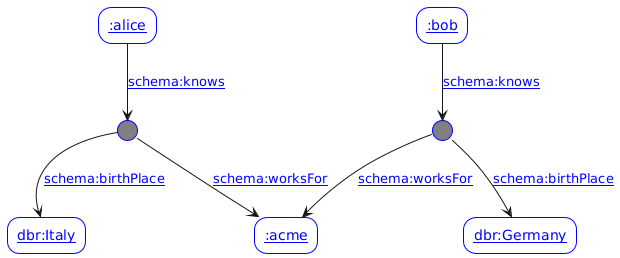

In [19]:
# @title
!rm -f out.puml out.png
uml = rudof.data2plantuml_file('out.puml')
!python -m plantuml out.puml
Image(f"out.png")

### Merging RDF data

In [20]:
rudof.reset_all()

You may have noticed that we did `rudof.reset_all()` in some of the previous examples. The reason is that by default, the `rdf_data_str()` method in `rudof`, merges the current RDF data with the data that has been read.

As RDF data models are defined as sets of triples, they support merging quite easily.

One RDF graph plus another RDf graph is another RDF graph. This is feature can be quite powerful and is one of the reasons why RDF can help data interoperability.

In [21]:
rudof.read_data_str("""
prefix : <http://example.org/>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>

:x a :Person     ;
   :name "Alice" ;
   :knows :y     .
:y a :Person     ;
   :name "Bob"   ;
   :knows :z     .
:z a :Person     ;
   :knows :x     .
""")

The RDF data can easily be merged with other data.

In [22]:
rudof.read_data_str("""
prefix : <http://example.org/>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>

:u a :Person     ;
   :name "Dave" ;
   :knows :y     .
:v a :Person     ;
   :name "Emily" ;
   :knows _:1    .
_:1 a :Person     ;
   :knows :x     .
""")

[{'filename': 'out.puml', 'gen_success': True}]


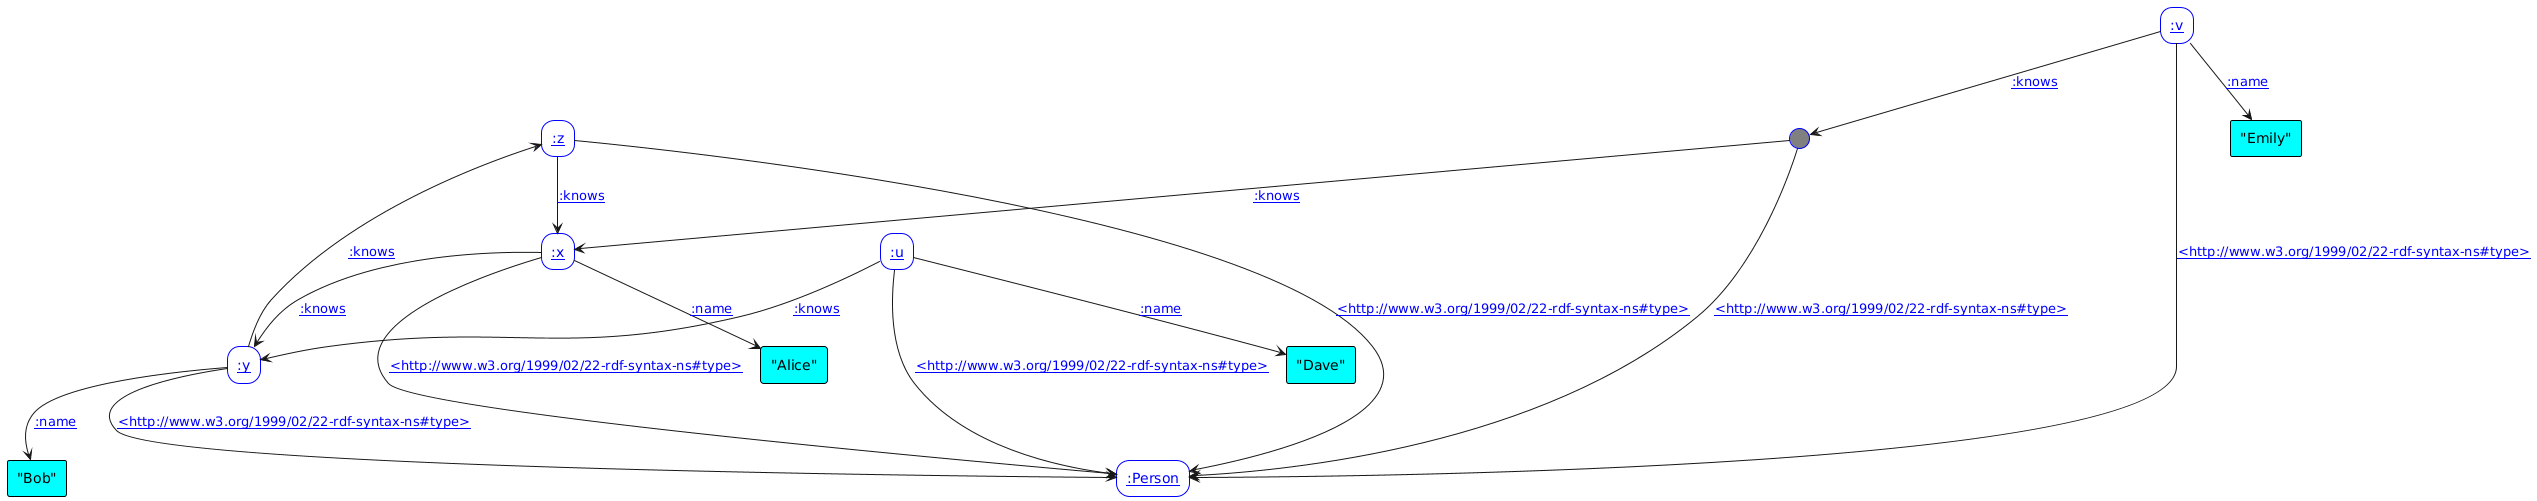

In [23]:
!rm -f out.puml out.png
uml = rudof.data2plantuml_file('out.puml')
!python -m plantuml out.puml
Image(f"out.png")

### Different RDF data formats

There are several RDF data formats like:


*   N-Triples: this is the most basic format where an RDF graph is defined as a list of triples ended by a dot. This format doesn't define any syntactic sugar like prefix declarations or other abreviations.
*   Turtle: this format is intended for human-readability. It contains some syntactic sugar like prefix declarations, numeric literals or joining together statements with the same subject-predicate using a comma or the same subject using a semicolon.
* RDF/XML: this format was one of the first RDF formats and was defined when XML was popular.
* JSON-LD: this format is a representation of RDF in JSON.

Rudof can be used to convert between different RDF formats.


The following code converts the current RDF data to N-Triples:

In [24]:
from pyrudof import RDFFormat
str = rudof.serialize_data(format=RDFFormat.NTriples)
print(str)

<http://example.org/z> <http://example.org/knows> <http://example.org/x> .
<http://example.org/z> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.org/Person> .
<http://example.org/v> <http://example.org/name> "Emily" .
<http://example.org/v> <http://example.org/knows> _:1 .
<http://example.org/v> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.org/Person> .
<http://example.org/x> <http://example.org/name> "Alice" .
<http://example.org/x> <http://example.org/knows> <http://example.org/y> .
<http://example.org/x> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.org/Person> .
<http://example.org/u> <http://example.org/name> "Dave" .
<http://example.org/u> <http://example.org/knows> <http://example.org/y> .
<http://example.org/u> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.org/Person> .
<http://example.org/y> <http://example.org/name> "Bob" .
<http://example.org/y> <http://example.org/knows> <http://example.org/z> .

The following code converts it to RDF/XML:

In [25]:
str = rudof.serialize_data(format=RDFFormat.RDFXML)
print(str)

<?xml version="1.0" encoding="UTF-8"?>
<rdf:RDF xmlns="http://example.org/" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:xsd="http://www.w3.org/2001/XMLSchema#">
	<rdf:Description rdf:about="http://example.org/z">
		<knows rdf:resource="http://example.org/x"/>
		<rdf:type rdf:resource="http://example.org/Person"/>
	</rdf:Description>
	<rdf:Description rdf:about="http://example.org/v">
		<name>Emily</name>
		<knows rdf:nodeID="1"/>
		<rdf:type rdf:resource="http://example.org/Person"/>
	</rdf:Description>
	<rdf:Description rdf:about="http://example.org/x">
		<name>Alice</name>
		<knows rdf:resource="http://example.org/y"/>
		<rdf:type rdf:resource="http://example.org/Person"/>
	</rdf:Description>
	<rdf:Description rdf:about="http://example.org/u">
		<name>Dave</name>
		<knows rdf:resource="http://example.org/y"/>
		<rdf:type rdf:resource="http://example.org/Person"/>
	</rdf:Description>
	<rdf:Description rdf:about="http://example.org/y">
		<name>Bob</name>
		<knows rdf:

The following code converts it to JSON-LD:

In [26]:
str = rudof.serialize_data(format=RDFFormat.JsonLd)
print(str)

[{"@id":"http://example.org/z","http://example.org/knows":[{"@id":"http://example.org/x"}],"http://www.w3.org/1999/02/22-rdf-syntax-ns#type":[{"@id":"http://example.org/Person"}]},{"@id":"http://example.org/v","http://example.org/name":[{"@value":"Emily"}],"http://example.org/knows":[{"@id":"_:1"}],"http://www.w3.org/1999/02/22-rdf-syntax-ns#type":[{"@id":"http://example.org/Person"}]},{"@id":"http://example.org/x","http://example.org/name":[{"@value":"Alice"}],"http://example.org/knows":[{"@id":"http://example.org/y"}],"http://www.w3.org/1999/02/22-rdf-syntax-ns#type":[{"@id":"http://example.org/Person"}]},{"@id":"http://example.org/u","http://example.org/name":[{"@value":"Dave"}],"http://example.org/knows":[{"@id":"http://example.org/y"}],"http://www.w3.org/1999/02/22-rdf-syntax-ns#type":[{"@id":"http://example.org/Person"}]},{"@id":"http://example.org/y","http://example.org/name":[{"@value":"Bob"}],"http://example.org/knows":[{"@id":"http://example.org/z"}],"http://www.w3.org/1999/0

## Running SPARQL queries

SPARQL is an RDF query language which is also available in rudof:

In [27]:
from pyrudof import Rudof, RudofConfig, QuerySolutions
rudof = Rudof(RudofConfig())
rudof.reset_all()

In [28]:
rdf = """
prefix :    <http://example.org/>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>

:alice a :Person ;
 :name      "Alice"                ;
 :birthDate "2005-03-01"^^xsd:date ;
 :worksFor  :acme                   .
:bob a :Person   ;
 :name      "Robert Smith"         ;
 :birthDate "2003-01-02"^^xsd:date ;
 :worksFor  :acme  .
:acme a :Company ;
 :name "Acme Inc." .
"""
rudof.read_data_str(rdf)

In [29]:
query = """
PREFIX : <http://example.org/>

SELECT ?person ?name ?date ?company WHERE {
  ?person a          :Person ;
          :name      ?name   ;
          :birthDate ?date   ;
          :worksFor  ?c   .
  ?c      :name      ?company .
}
"""

results = rudof.run_query_str(query)


Show the results:

In [31]:
print(results.show())

╭───┬─────────┬────────────────┬────────────────────────┬─────────────╮
│   │ ?person │ ?name          │ ?date                  │ ?company    │
├───┼─────────┼────────────────┼────────────────────────┼─────────────┤
│ 1 │ :alice  │ "Alice"        │ "2005-03-01"^^xsd:date │ "Acme Inc." │
├───┼─────────┼────────────────┼────────────────────────┼─────────────┤
│ 2 │ :bob    │ "Robert Smith" │ "2003-01-02"^^xsd:date │ "Acme Inc." │
╰───┴─────────┴────────────────┴────────────────────────┴─────────────╯

